In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import matplotlib.pyplot as plt

#import plotly.express as px
#import plotly.offline as pyo
import plotly.graph_objects as go
#from plotly.offline import plot
#import plotly.io as pio

In [2]:
import mapping

## Getting data from NHL, NBA, MLB, NFL and the corresponding populations from the teams region

In [3]:
nhl_df=pd.read_csv("datasets/nhl.csv")
nba_df=pd.read_csv("datasets/nba.csv")
mlb_df=pd.read_csv("datasets/mlb.csv")
nfl_df=pd.read_csv("datasets/nfl.csv")

In [4]:
cities=pd.read_html("datasets/wikipedia_data.html")[1]
cities=cities.iloc[:-1,[0,3,5,6,7,8]]

# Data Cleaning (Whitespaces, '*', ...) and Mapping the sports team to the region

In [5]:
#Cleaning the cities dataset
cities = cities.rename(columns={cities.columns[1]:'Population'})
cities = cities[['Metropolitan area','Population']].set_index('Metropolitan area')
cities.index = cities.index.str.strip()
cities['Population'] = cities['Population'].astype('float64')

In [6]:
#Looking at a specific year for the sports datasets
nhl_df = nhl_df[nhl_df['year']==2018]
nba_df = nba_df[nba_df['year']==2018]
mlb_df = mlb_df[mlb_df['year']==2018]
nfl_df = nfl_df[nfl_df['year']==2018]

In [7]:
#Cleaning NHL Dataset
nhl_df['team'] = nhl_df['team'].str.replace('*','')
nhl_df = nhl_df[['team','W','L']].set_index('team')
nhl_df = nhl_df.drop(['Atlantic Division','Metropolitan Division',
                      'Central Division','Pacific Division'])

In [8]:
#Cleaning NBA Dataset
nba_df['team'] = nba_df['team'].str.replace('*','')
nba_df['team'] = nba_df['team'].str.replace('\([\d]*\)','',regex=True)
nba_df['team'] = nba_df['team'].str.strip()
nba_df = nba_df[['team','W','L']].set_index('team')

In [9]:
#Cleaning MLB Dataset
mlb_df['team'] = mlb_df['team'].str.strip()
mlb_df = mlb_df[['team','W','L']].set_index('team')

In [10]:
#Cleaning NFL Dataset
nfl_df['team'] = nfl_df['team'].str.replace('*','')
nfl_df['team'] = nfl_df['team'].str.replace('+','')
nfl_df['team'] = nfl_df['team'].str.strip()
nfl_df = nfl_df[['team','W','L']].set_index('team')
nfl_df = nfl_df.drop(['AFC East','AFC North','AFC South','AFC West',
                     'NFC East','NFC North','NFC South','NFC West'])

## Calculating WIN/LOSS-Ratios (W/L = W / (W + L)) and Group by mapping to region
### If there is more than one team in a region &rightarrow; mean(W/L) 

In [11]:
#NHL data
nhl_df[['W','L']] = nhl_df[['W','L']].astype('float64')
nhl_df['W/L'] = nhl_df['W']/(nhl_df['L']+nhl_df['W'])
nhl_df = nhl_df['W/L'].groupby(mapping.nhl).mean()
nhl_df.index.names = ['Metropolitan area']
nhl_df.index = nhl_df.index.str.strip()

In [12]:
#NBA data
nba_df[['W','L']] = nba_df[['W','L']].astype('float64')
nba_df['W/L'] = nba_df['W']/(nba_df['W']+nba_df['L'])
nba_df = nba_df['W/L'].groupby(mapping.nba).mean()
nba_df.index.names = ['Metropolitan area']

In [13]:
#MLB data
mlb_df[['W','L']] = mlb_df[['W','L']].astype('float64')
mlb_df['W/L'] = mlb_df['W']/(mlb_df['W']+mlb_df['L'])
mlb_df = mlb_df['W/L'].groupby(mapping.mlb).mean()
mlb_df.index.names = ['Metropolitan area']

In [14]:
#NFL data
nfl_df[['W','L']] = nfl_df[['W','L']].astype('float64')
nfl_df['W/L'] = nfl_df['W']/(nfl_df['W']+nfl_df['L'])
nfl_df = nfl_df['W/L'].groupby(mapping.nfl).mean()
nfl_df.index.names = ['Metropolitan area']

## Merge sports and population data together and calculate the correlation of W/L-Ratio to population and plot into scatter plot and geo plot

## NHL

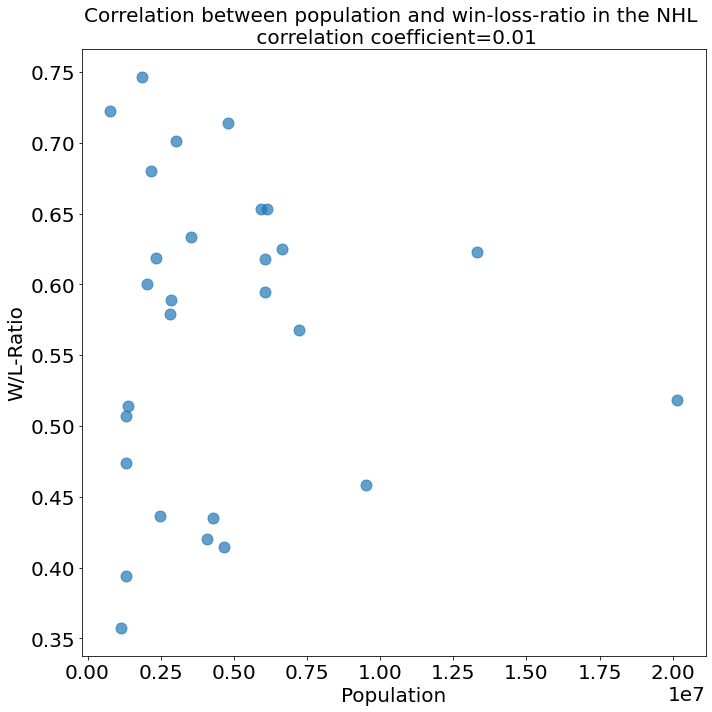

In [15]:
new_df = pd.merge(nhl_df,cities,how='inner',on='Metropolitan area')
    
population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

corrcoef = stats.pearsonr(population_by_region, win_loss_by_region)[0]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(population_by_region,win_loss_by_region,s=120,alpha=0.7)
plt.title('Correlation between population and win-loss-ratio in the NHL \n correlation coefficient={:.2f}'.format(corrcoef),
         fontsize=20)
plt.xlabel('Population',fontsize=20)
plt.ylabel('W/L-Ratio',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.offsetText.set_fontsize(20)
#plt.show()
plt.tight_layout()
plt.savefig('images/nhl_correlation.png')

In [16]:
lat_lon = pd.Series(mapping.lat_lon)
lat_lon.name = 'lat_lon'
new_df = pd.merge(new_df,lat_lon,how='inner',left_index=True,right_index=True)

In [17]:
new_df['lat'] = new_df['lat_lon'].map(lambda x: x[0])
new_df['lon'] = new_df['lat_lon'].map(lambda x: x[1])

In [18]:
#fig, ax = plt.subplots(figsize=(12,9))
#_ = plt.scatter(list(new_df['lon']),list(new_df['lat']),
#            s=[size/50000 for size in list(new_df['Population'])],
#           c=list(new_df['W/L']),cmap='PiYG')
#cbar = plt.colorbar(_)
#cbar.ax.set_ylabel('W/L-Ratio')
#plt.show()

new_df['text'] = new_df['Population'].apply(
    lambda x: new_df.index.where(new_df['Population']==x).dropna() if x>7500000 else None)

fig = go.Figure()

fig.update_layout(geo=dict(
    scope = 'north america',
    showcountries=True,
    landcolor="#ffddab",
    lataxis = dict(range=[25,60]),
    lonaxis = dict(range=[-130,-60])
    ))

fig.update_layout(title_text='Map of NHL teams with their Win-Loss-Ratio and Population',
                  title_x=0.5, title_y=0.85,title_font_size=25)


fig.add_trace(go.Scattergeo(
    lon=new_df['lon'],
    lat=new_df['lat'],
    text=new_df['text'],
    hovertext=new_df.index,
    mode='markers+text',
    textposition='middle center',
    marker = dict(
        size = [size/200000 for size in list(new_df['Population'])],
        color = new_df['W/L'],
        colorscale ='Greens',
        colorbar = dict(
            len = 0.75,
            title = 'Win-Loss-Ratio'))))


fig.write_html("images/nhl_map.html")
#plot(fig,'test.html')

## NBA

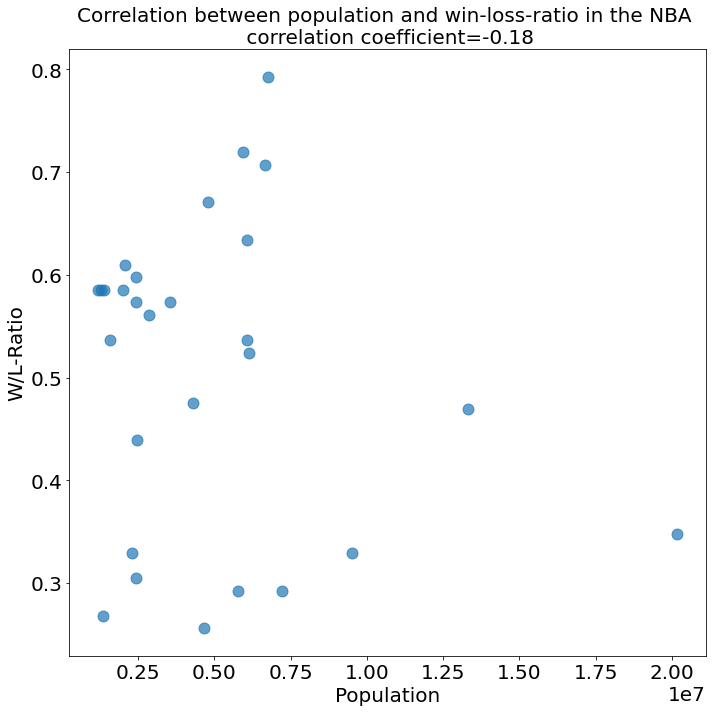

In [19]:
new_df = pd.merge(nba_df,cities,how='inner',on='Metropolitan area')

population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

corrcoef = stats.pearsonr(population_by_region, win_loss_by_region)[0]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(population_by_region,win_loss_by_region,s=120,alpha=0.7)
plt.title('Correlation between population and win-loss-ratio in the NBA \n correlation coefficient={:.2f}'.format(corrcoef),
         fontsize=20)
plt.xlabel('Population',fontsize=20)
plt.ylabel('W/L-Ratio',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.offsetText.set_fontsize(20)
#plt.show()
plt.tight_layout()
plt.savefig('images/nba_correlation.png')

In [20]:
lat_lon = pd.Series(mapping.lat_lon)
lat_lon.name = 'lat_lon'
new_df = pd.merge(new_df,lat_lon,how='inner',left_index=True,right_index=True)

In [21]:
new_df['lat'] = new_df['lat_lon'].map(lambda x: x[0])
new_df['lon'] = new_df['lat_lon'].map(lambda x: x[1])

In [22]:
new_df['text'] = new_df['Population'].apply(
    lambda x: new_df.index.where(new_df['Population']==x).dropna() if x>7500000 else None)

fig = go.Figure()

fig.update_layout(geo=dict(
    scope = 'north america',
    showcountries=True,
    landcolor="#ffddab",
    lataxis = dict(range=[25,60]),
    lonaxis = dict(range=[-130,-60])
    ))

fig.update_layout(title_text='Map of NBA teams with their Win-Loss-Ratio and Population',
                  title_x=0.5, title_y=0.85,title_font_size=25)


fig.add_trace(go.Scattergeo(
    lon=new_df['lon'],
    lat=new_df['lat'],
    text=new_df['text'],
    hovertext=new_df.index,
    mode='markers+text',
    textposition='middle center',
    marker = dict(
        size = [size/200000 for size in list(new_df['Population'])],
        color = new_df['W/L'],
        colorscale ='Greens',
        colorbar = dict(
            len = 0.75,
            title = 'Win-Loss-Ratio'))))


fig.write_html("images/nba_map.html")

## MLB

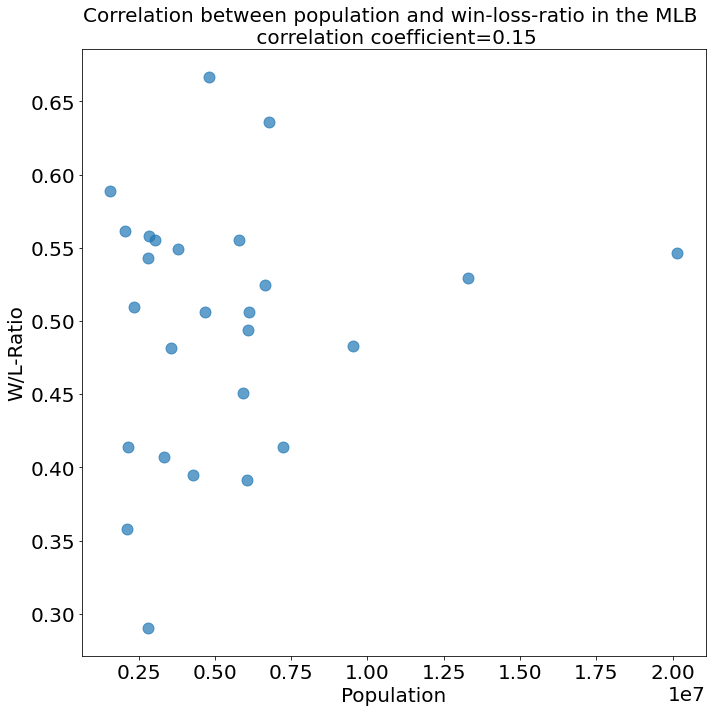

In [23]:
new_df = pd.merge(mlb_df,cities,how='inner',on='Metropolitan area')

population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

corrcoef = stats.pearsonr(population_by_region, win_loss_by_region)[0]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(population_by_region,win_loss_by_region,s=120,alpha=0.7)
plt.title('Correlation between population and win-loss-ratio in the MLB \n correlation coefficient={:.2f}'.format(corrcoef),
         fontsize=20)
plt.xlabel('Population',fontsize=20)
plt.ylabel('W/L-Ratio',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.offsetText.set_fontsize(20)
#plt.show()
plt.tight_layout()
plt.savefig('images/mlb_correlation.png')

In [24]:
lat_lon = pd.Series(mapping.lat_lon)
lat_lon.name = 'lat_lon'
new_df = pd.merge(new_df,lat_lon,how='inner',left_index=True,right_index=True)

In [25]:
new_df['lat'] = new_df['lat_lon'].map(lambda x: x[0])
new_df['lon'] = new_df['lat_lon'].map(lambda x: x[1])

In [26]:
new_df['text'] = new_df['Population'].apply(
    lambda x: new_df.index.where(new_df['Population']==x).dropna() if x>7500000 else None)

fig = go.Figure()

fig.update_layout(geo=dict(
    scope = 'north america',
    showcountries=True,
    landcolor="#ffddab",
    lataxis = dict(range=[25,60]),
    lonaxis = dict(range=[-130,-60])
    ))

fig.update_layout(title_text='Map of MLB teams with their Win-Loss-Ratio and Population',
                  title_x=0.5, title_y=0.85,title_font_size=25)


fig.add_trace(go.Scattergeo(
    lon=new_df['lon'],
    lat=new_df['lat'],
    text=new_df['text'],
    hovertext=new_df.index,
    mode='markers+text',
    textposition='middle center',
    marker = dict(
        size = [size/200000 for size in list(new_df['Population'])],
        color = new_df['W/L'],
        colorscale ='Greens',
        colorbar = dict(
            len = 0.75,
            title = 'Win-Loss-Ratio'))))


fig.write_html("images/mlb_map.html")

## NFL

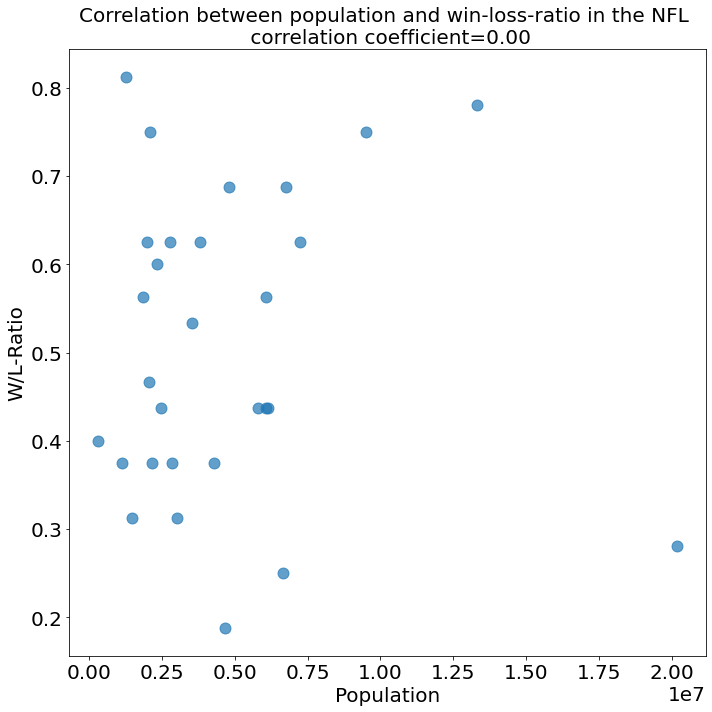

In [27]:
new_df = pd.merge(nfl_df,cities,how='inner',on='Metropolitan area')

population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

corrcoef = stats.pearsonr(population_by_region, win_loss_by_region)[0]

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(population_by_region,win_loss_by_region,s=120,alpha=0.7)
plt.title('Correlation between population and win-loss-ratio in the NFL \n correlation coefficient={:.2f}'.format(corrcoef),
         fontsize=20)
plt.xlabel('Population',fontsize=20)
plt.ylabel('W/L-Ratio',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.offsetText.set_fontsize(20)
#plt.show()
plt.tight_layout()
plt.savefig('images/nfl_correlation.png')

In [28]:
lat_lon = pd.Series(mapping.lat_lon)
lat_lon.name = 'lat_lon'
new_df = pd.merge(new_df,lat_lon,how='inner',left_index=True,right_index=True)

In [29]:
new_df['lat'] = new_df['lat_lon'].map(lambda x: x[0])
new_df['lon'] = new_df['lat_lon'].map(lambda x: x[1])

In [30]:
new_df['text'] = new_df['Population'].apply(
    lambda x: new_df.index.where(new_df['Population']==x).dropna() if x>7500000 else None)

fig = go.Figure()

fig.update_layout(geo=dict(
    scope = 'north america',
    showcountries=True,
    landcolor="#ffddab",
    lataxis = dict(range=[25,60]),
    lonaxis = dict(range=[-130,-60])
    ))

fig.update_layout(title_text='Map of NFL teams with their Win-Loss-Ratio and Population',
                  title_x=0.5, title_y=0.85,title_font_size=25)


fig.add_trace(go.Scattergeo(
    lon=new_df['lon'],
    lat=new_df['lat'],
    text=new_df['text'],
    hovertext=new_df.index,
    mode='markers+text',
    textposition='middle center',
    marker = dict(
        size = [size/200000 for size in list(new_df['Population'])],
        color = new_df['W/L'],
        colorscale ='Greens',
        colorbar = dict(
            len = 0.75,
            title = 'Win-Loss-Ratio'))))


fig.write_html("images/nfl_map.html")